In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load training CSVs
annual_s2 = pd.read_csv('training_thin100_s2_annual_bands.csv')
seasonal_s2 = pd.read_csv('training_thin100_s2_seasonal_bands.csv')
annual_s1 = pd.read_csv('training_thin100_s1_annual_filtered.csv')
seasonal_s1 = pd.read_csv('training_thin100_s1_seasonal_filtered.csv')
topo = pd.read_csv("training_thin100_topo.csv")


# Ensure correct data types
for df in [annual_s2, seasonal_s2, annual_s1, seasonal_s1, topo]:
    df['location_id'] = df['location_id'].astype(str)
    df['class'] = df['class'].astype(int)


In [2]:
def get_largest_abs_ndwi_change(df):
    results = []
    for loc, group in df.groupby('location_id'):
        grp = group[group['year'] > 2017].sort_values('year')
        ndwi = grp['NDWI'].values
        years = grp['year'].values
        cls = group['class'].iloc[0]
        if len(ndwi) < 2:
            change_year = None
            change_mag = 0
        else:
            diffs = np.diff(ndwi)
            abs_diffs = np.abs(diffs)
            idx = np.argmax(abs_diffs)
            change_year = years[idx]  # Year BEFORE the largest change
            change_mag = abs_diffs[idx]
        results.append({
            'location_id': loc,
            'class': cls,
            'change_year': change_year,
            'change_mag': change_mag,
        })
    return pd.DataFrame(results)

change_info = get_largest_abs_ndwi_change(annual_s2)


In [3]:
def extract_features(
    annual_s2, seasonal_s2, seasonal_s1, annual_s1, change_info, topo, location_ids=None
):
    def linear_regression(x, y):
        if len(x) < 2:
            return [np.nan] * 2
        res = linregress(x, y)
        return [res.slope, res.intercept]

    def smooth_series(series, window_length=5, polyorder=2):
        series = np.asarray(series)
        if len(series) < window_length or window_length % 2 == 0:
            return series
        try:
            return savgol_filter(series, window_length=window_length, polyorder=polyorder)
        except:
            return series

    def fft_features(series, n=4):
        series = np.asarray(series)
        series = series[~np.isnan(series)]
        if len(series) < n:
            return [np.nan] * (2 * n)
        smoothed = smooth_series(series)
        smoothed = smoothed - np.mean(smoothed)
        fft_vals = np.fft.fft(smoothed)
        magnitudes = np.abs(fft_vals[1:n+1])
        phases = np.angle(fft_vals[1:n+1])
        result = list(magnitudes) + list(phases)
        if len(result) < 2 * n:
            result += [np.nan] * (2 * n - len(result))
        return result

    def aggregate_stats(arr):
        arr = np.asarray(arr)
        return [np.nanmin(arr), np.nanmax(arr), np.nanmean(arr), np.nanstd(arr)] if len(arr) else [np.nan]*4

    features = []
    ids_to_use = set(change_info['location_id']) if location_ids is None else set(location_ids)

    for idx, row in change_info.iterrows():
        loc_id = row['location_id']
        if loc_id not in ids_to_use:
            continue

        topo_row = topo[topo['location_id'] == loc_id]
        if topo_row.empty:
            elevation = slope_val = aspect_val = np.nan
        else:
            elevation = topo_row.iloc[0]['elevation']
            slope_val = topo_row.iloc[0]['slope']
            aspect_val = topo_row.iloc[0]['aspect']

        change_year = row['change_year']
        gt_class = row['class']

        ann2 = annual_s2[(annual_s2['location_id'] == loc_id) & (annual_s2['year'] >= 2019)].copy()
        ann1 = annual_s1[(annual_s1['location_id'] == loc_id) & (annual_s1['year'] >= 2019)].copy()
        seas2 = seasonal_s2[seasonal_s2['location_id'] == loc_id].copy()
        seas1 = seasonal_s1[seasonal_s1['location_id'] == loc_id].copy()

        if not pd.isnull(change_year):
            ann2_bf, ann2_af = ann2[ann2['year'] < change_year], ann2[ann2['year'] >= change_year]
            ann1_bf, ann1_af = ann1[ann1['year'] < change_year], ann1[ann1['year'] >= change_year]
            seas2_bf, seas2_af = seas2[seas2['year'] < change_year], seas2[seas2['year'] >= change_year]
            seas1_bf, seas1_af = seas1[seas1['year'] < change_year], seas1[seas1['year'] >= change_year]
        else:
            ann2_bf = ann2_af = ann2
            ann1_bf = ann1_af = ann1
            seas2_bf = seas2_af = seas2
            seas1_bf = seas1_af = seas1

        s2_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI']
        lr_s2_features = {}
        for band in s2_bands:
            for suffix, df in zip(['bf', 'af'], [ann2_bf, ann2_af]):
                values = linear_regression(df['year'], df[band]) if band in df else [np.nan]*2
                lr_s2_features[f'lr_{band.lower()}_{suffix}_slope'] = values[0]
                lr_s2_features[f'lr_{band.lower()}_{suffix}_intercept'] = values[1]

        lr_vv_bf = linear_regression(ann1_bf['year'], ann1_bf['VV']) if 'VV' in ann1_bf else [np.nan]*2
        lr_vv_af = linear_regression(ann1_af['year'], ann1_af['VV']) if 'VV' in ann1_af else [np.nan]*2
        lr_vh_bf = linear_regression(ann1_bf['year'], ann1_bf['VH']) if 'VH' in ann1_bf else [np.nan]*2
        lr_vh_af = linear_regression(ann1_af['year'], ann1_af['VH']) if 'VH' in ann1_af else [np.nan]*2
        lr_vvvh_bf = linear_regression(ann1_bf['year'], ann1_bf['VVVH']) if 'VVVH' in ann1_bf else [np.nan]*2
        lr_vvvh_af = linear_regression(ann1_af['year'], ann1_af['VVVH']) if 'VVVH' in ann1_af else [np.nan]*2

        fft_s2_features = {}
        for band in s2_bands:
            for suffix, df in zip(['bf', 'af'], [seas2_bf, seas2_af]):
                fft = fft_features(df[band]) if band in df else [np.nan]*8
                for i, key in enumerate(['mag1','mag2','mag3','mag4','ph1','ph2','ph3','ph4']):
                    fft_s2_features[f'fft_{band.lower()}_{suffix}_{key}'] = fft[i]

        fft_vv_bf = fft_features(seas1_bf['VV']) if 'VV' in seas1_bf else [np.nan]*8
        fft_vv_af = fft_features(seas1_af['VV']) if 'VV' in seas1_af else [np.nan]*8
        fft_vh_bf = fft_features(seas1_bf['VH']) if 'VH' in seas1_bf else [np.nan]*8
        fft_vh_af = fft_features(seas1_af['VH']) if 'VH' in seas1_af else [np.nan]*8
        fft_vvvh_bf = fft_features(seas1_bf['VVVH']) if 'VVVH' in seas1_bf else [np.nan]*8
        fft_vvvh_af = fft_features(seas1_af['VVVH']) if 'VVVH' in seas1_af else [np.nan]*8

        stats_vv_bf = aggregate_stats(seas1_bf['VV']) if 'VV' in seas1_bf else [np.nan]*4
        stats_vv_af = aggregate_stats(seas1_af['VV']) if 'VV' in seas1_af else [np.nan]*4
        stats_vh_bf = aggregate_stats(seas1_bf['VH']) if 'VH' in seas1_bf else [np.nan]*4
        stats_vh_af = aggregate_stats(seas1_af['VH']) if 'VH' in seas1_af else [np.nan]*4
        stats_vvvh_bf = aggregate_stats(seas1_bf['VVVH']) if 'VVVH' in seas1_bf else [np.nan]*4
        stats_vvvh_af = aggregate_stats(seas1_af['VVVH']) if 'VVVH' in seas1_af else [np.nan]*4

        f = {
            'location_id': loc_id,
            'class': gt_class,
            'change_year': change_year,
            'elevation': elevation,
            'slope': slope_val,
            'aspect': aspect_val,
            'lr_vv_bf_slope': lr_vv_bf[0], 'lr_vv_bf_intercept': lr_vv_bf[1],
            'lr_vv_af_slope': lr_vv_af[0], 'lr_vv_af_intercept': lr_vv_af[1],
            'lr_vh_bf_slope': lr_vh_bf[0], 'lr_vh_bf_intercept': lr_vh_bf[1],
            'lr_vh_af_slope': lr_vh_af[0], 'lr_vh_af_intercept': lr_vh_af[1],
            'lr_vvvh_bf_slope': lr_vvvh_bf[0], 'lr_vvvh_bf_intercept': lr_vvvh_bf[1],
            'lr_vvvh_af_slope': lr_vvvh_af[0], 'lr_vvvh_af_intercept': lr_vvvh_af[1],
        }

        fft_keys = ['mag1', 'mag2', 'mag3', 'mag4', 'ph1', 'ph2', 'ph3', 'ph4']
        for i, key in enumerate(fft_keys):
            f[f'fft_vv_bf_{key}'] = fft_vv_bf[i]
            f[f'fft_vv_af_{key}'] = fft_vv_af[i]
            f[f'fft_vh_bf_{key}'] = fft_vh_bf[i]
            f[f'fft_vh_af_{key}'] = fft_vh_af[i]
            f[f'fft_vvvh_bf_{key}'] = fft_vvvh_bf[i]
            f[f'fft_vvvh_af_{key}'] = fft_vvvh_af[i]

        for k, v in zip(['min', 'max', 'mean', 'std'], stats_vv_bf): f[f'stats_vv_bf_{k}'] = v
        for k, v in zip(['min', 'max', 'mean', 'std'], stats_vv_af): f[f'stats_vv_af_{k}'] = v
        for k, v in zip(['min', 'max', 'mean', 'std'], stats_vh_bf): f[f'stats_vh_bf_{k}'] = v
        for k, v in zip(['min', 'max', 'mean', 'std'], stats_vh_af): f[f'stats_vh_af_{k}'] = v
        for k, v in zip(['min', 'max', 'mean', 'std'], stats_vvvh_bf): f[f'stats_vvvh_bf_{k}'] = v
        for k, v in zip(['min', 'max', 'mean', 'std'], stats_vvvh_af): f[f'stats_vvvh_af_{k}'] = v

        f.update(lr_s2_features)
        f.update(fft_s2_features)

        features.append(f)

    return pd.DataFrame(features)


In [4]:
features_df = extract_features(annual_s2, seasonal_s2, seasonal_s1, annual_s1, change_info, topo)

In [5]:
from sklearn.model_selection import train_test_split
meta = features_df[['location_id', 'class']].drop_duplicates()
train_ids, val_ids = train_test_split(
    meta, 
    test_size=0.4, 
    stratify=meta['class'], 
    random_state=42
)

train_set = set(train_ids['location_id'])
features_df['split'] = features_df['location_id'].apply(
    lambda x: 'train' if x in train_set else 'val'
)



In [6]:
# Select feature columns (exclude IDs, split info, and label)
non_feature_cols = ['location_id', 'class', 'split', 'change_year']
feature_cols = [c for c in features_df.columns if c not in non_feature_cols]

# Prepare X/y for train and validation
train = features_df[features_df['split'] == 'train']
val = features_df[features_df['split'] == 'val']

X_train = train[feature_cols].copy()
y_train = train['class'].astype(int)
X_val = val[feature_cols].copy()
y_val = val['class'].astype(int)

# Impute NaNs with median
imp = SimpleImputer(strategy='median')
X_train_imp = imp.fit_transform(X_train)
X_val_imp = imp.transform(X_val)


In [7]:
rf = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_leaf=1, class_weight='balanced', random_state=0)
rf.fit(X_train_imp, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=0)

In [8]:
# Predict
y_pred = rf.predict(X_val_imp)

# Dynamically get class labels from the validation set
# Class labels
class_map = {
    0: 'Always Forest',
    1: 'Forest → Oil Palm',
}
unique_classes = sorted(y_val.unique())
target_names = [class_map.get(c, f"Class {c}") for c in unique_classes]

# Print evaluation
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred, labels=unique_classes, target_names=target_names, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Accuracy: 0.95

Classification Report:
                   precision    recall  f1-score   support

    Always Forest      0.950     0.950     0.950        20
Forest → Oil Palm      0.950     0.950     0.950        20

         accuracy                          0.950        40
        macro avg      0.950     0.950     0.950        40
     weighted avg      0.950     0.950     0.950        40

Confusion Matrix:
[[19  1]
 [ 1 19]]


In [9]:
# cm = confusion_matrix(y_val, y_pred)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=np.unique(y_val),
#             yticklabels=np.unique(y_val))
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()


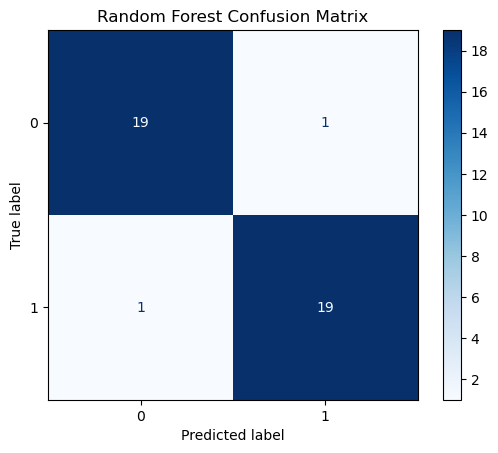

In [10]:
cm = confusion_matrix(y_val, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.savefig('confusion_matrix_val.png', dpi=300)
plt.show()



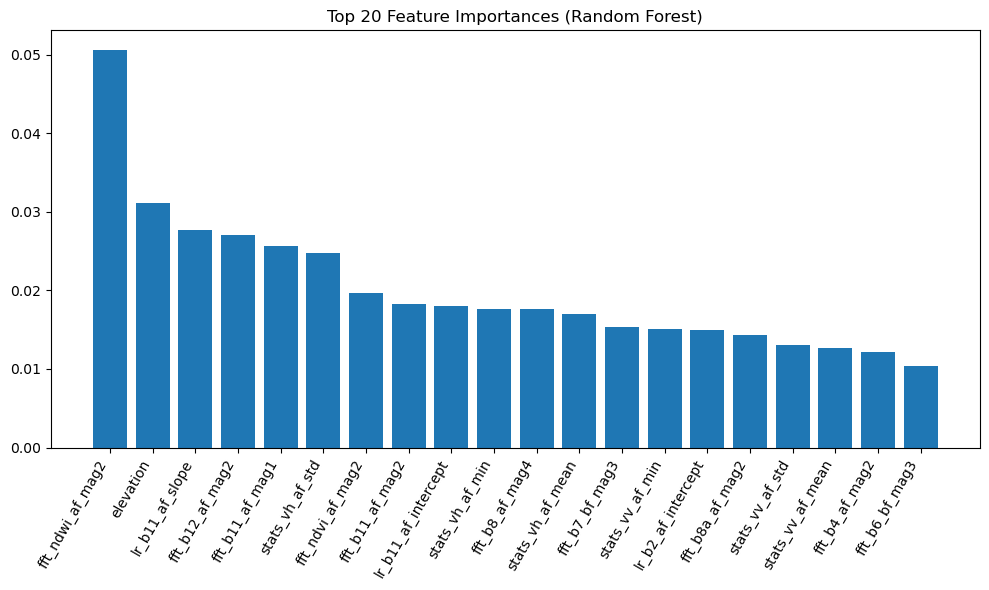

In [11]:
importances = rf.feature_importances_
feat_names = np.array(feature_cols)
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(20), importances[idx][:20])
plt.xticks(range(20), feat_names[idx][:20], rotation=60, ha='right')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig('top_importance.png', dpi=300)
plt.show()


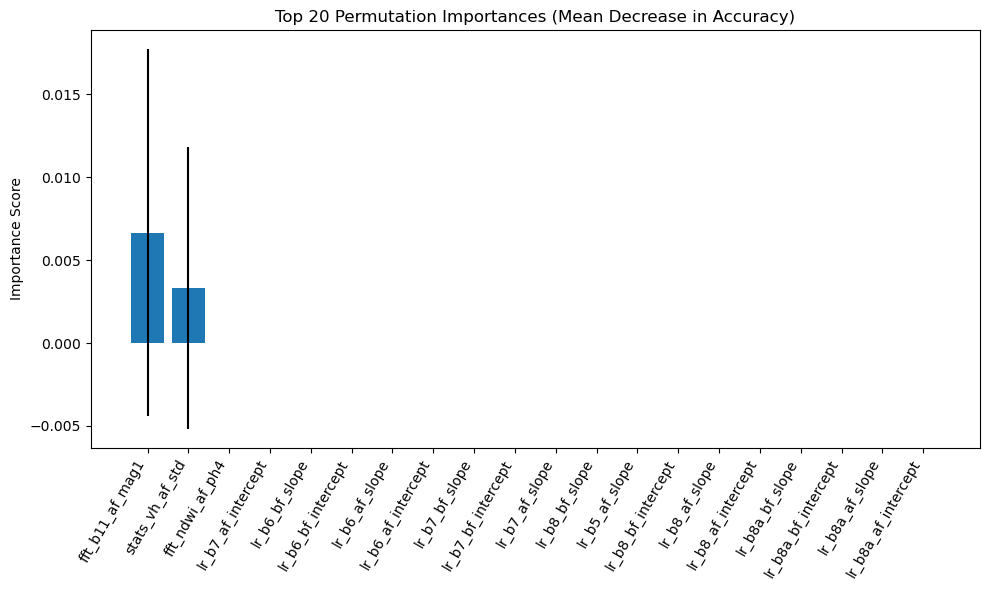

In [12]:
from sklearn.inspection import permutation_importance

# Permutation Importance
result = permutation_importance(
    rf, X_val_imp, y_val,
    n_repeats=30,
    random_state=0,
    n_jobs=-1
)

# Get importance means and standard deviations
perm_importances = result.importances_mean
perm_std = result.importances_std
perm_idx = np.argsort(perm_importances)[::-1]
feat_names = np.array(feature_cols)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(20), perm_importances[perm_idx][:20], yerr=perm_std[perm_idx][:20], align='center')
plt.xticks(range(20), feat_names[perm_idx][:20], rotation=60, ha='right')
plt.title('Top 20 Permutation Importances (Mean Decrease in Accuracy)')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('top_permutation_importance.png', dpi=300)
plt.show()



In [13]:
non_zero_count = np.sum(perm_importances==0)
print(f"Number of non-zero permutation importances: {non_zero_count}")


Number of non-zero permutation importances: 324


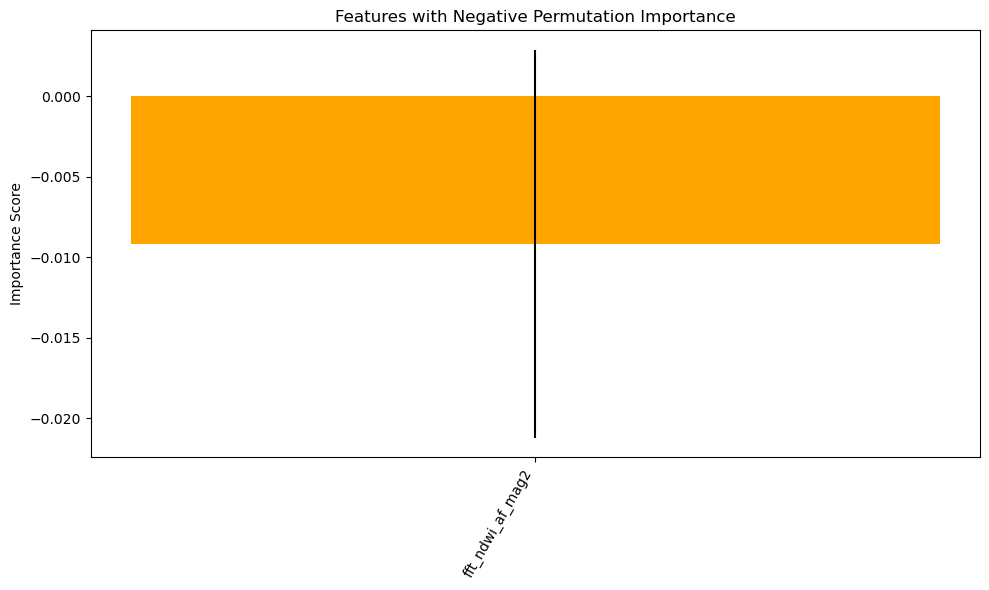

In [14]:
# Extract negatively important features
neg_idx = np.where(perm_importances < 0)[0]
neg_importances = perm_importances[neg_idx]
neg_std = perm_std[neg_idx]
neg_feat_names = feat_names[neg_idx]

# Sort them by importance
sorted_neg_idx = np.argsort(neg_importances)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_neg_idx)), neg_importances[sorted_neg_idx],
        yerr=neg_std[sorted_neg_idx], color='orange', align='center')
plt.xticks(range(len(sorted_neg_idx)), neg_feat_names[sorted_neg_idx], rotation=60, ha='right')
plt.title('Features with Negative Permutation Importance')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('negative_permutation_importance.png', dpi=300)
plt.show()


In [23]:
# Identify features with importance < 0
bad_feature_mask = perm_importances < 0
bad_features = feat_names[bad_feature_mask]
print("Features with importance < 0 (to be removed):")
print(bad_features)

# Create a new feature list excluding them
filtered_feature_cols = [f for f in feature_cols if f not in bad_features]

# Re-extract train/val data with filtered features
X_train_filtered = train[filtered_feature_cols].copy()
X_val_filtered = val[filtered_feature_cols].copy()

# Re-impute
X_train_filtered_imp = imp.fit_transform(X_train_filtered)
X_val_filtered_imp = imp.transform(X_val_filtered)

# Train a new model
rf_filtered = RandomForestClassifier(
    n_estimators=500, 
    max_depth=None, 
    min_samples_leaf=1, 
    class_weight='balanced',
    random_state=0
)
rf_filtered.fit(X_train_filtered_imp, y_train)

# Predict & Evaluate
y_pred_filtered = rf_filtered.predict(X_val_filtered_imp)

print("\nAccuracy after removing bad features:", accuracy_score(y_val, y_pred_filtered))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_filtered, labels=unique_classes, target_names=target_names, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_filtered))


Features with importance < -0.0025 (to be removed):
['stats_vh_af_min' 'stats_vh_af_std' 'fft_b2_af_mag4' 'fft_b11_af_mag4']

Accuracy after removing bad features: 0.925

Classification Report:
                   precision    recall  f1-score   support

    Always Forest      1.000     0.850     0.919        20
Forest → Oil Palm      0.870     1.000     0.930        20

         accuracy                          0.925        40
        macro avg      0.935     0.925     0.925        40
     weighted avg      0.935     0.925     0.925        40

Confusion Matrix:
[[17  3]
 [ 0 20]]


In [15]:
# Load test data
test_annual_s2 = pd.read_csv('test_thin_s2_annual_bands.csv')
test_seasonal_s2 = pd.read_csv('test_thin_s2_seasonal_bands.csv')
test_annual_s1 = pd.read_csv('test_thin_s1_annual_filtered.csv')
test_seasonal_s1 = pd.read_csv('test_thin_s1_seasonal_filtered.csv')
test_topo = pd.read_csv('test_thin_topo.csv')

# Ensure location_id is of string type
for df in [test_annual_s2, test_seasonal_s2, test_annual_s1, test_seasonal_s1, test_topo]:
    df['location_id'] = df['location_id'].astype(str)



In [16]:
change_info_test = get_largest_abs_ndwi_change(test_annual_s2)


In [17]:
features_test = extract_features(
    test_annual_s2, test_seasonal_s2, test_seasonal_s1, test_annual_s1, change_info_test, test_topo
)


In [18]:
# Prepare test features for prediction
non_feature_cols = ['location_id', 'class', 'change_year']
feature_cols = [c for c in features_test.columns if c not in non_feature_cols]

X_test = features_test[feature_cols].copy()
y_test = features_test['class'].astype(int)

# Impute missing values using training imputer
X_test_imp = imp.transform(X_test)

# Predict with trained model
y_pred_test = rf.predict(X_test_imp)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Test set accuracy:", accuracy_score(y_test, y_pred_test))
print("\nTest set classification report:")
# print(classification_report(y_test, y_pred_test, digits=3))
print(classification_report(
    y_test, y_pred_test, 
    labels=list(class_map.keys()), 
    target_names=target_names, 
    digits=3
))
print("Test set confusion matrix:")
print(confusion_matrix(y_test, y_pred_test))


Test set accuracy: 0.8105263157894737

Test set classification report:
                   precision    recall  f1-score   support

    Always Forest      0.904     0.705     0.792       146
Forest → Oil Palm      0.749     0.921     0.826       139

         accuracy                          0.811       285
        macro avg      0.826     0.813     0.809       285
     weighted avg      0.828     0.811     0.809       285

Test set confusion matrix:
[[103  43]
 [ 11 128]]


In [31]:
# Create a DataFrame with predictions and true labels
test_results = features_test[['location_id', 'class']].copy()
test_results['predicted'] = y_pred_test

# Identify misclassified points
misclassified = test_results[test_results['class'] != test_results['predicted']]

# Add prediction probabilities
probs = rf.predict_proba(X_test_imp)
for i, class_label in enumerate(rf.classes_):
    misclassified[f'prob_class_{class_label}'] = probs[:, i][misclassified.index]

# 4. Export to CSV
misclassified.to_csv("misclassified_points.csv", index=False)


C:\Users\b1106742\AppData\Local\Temp\ipykernel_49348\3847211304.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified[f'prob_class_{class_label}'] = probs[:, i][misclassified.index]
C:\Users\b1106742\AppData\Local\Temp\ipykernel_49348\3847211304.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified[f'prob_class_{class_label}'] = probs[:, i][misclassified.index]
